# ID3

## Entropy in Information Theory

The entropy $H$ of a set of probabilities $p_i$ is:

\begin{equation}
Entropy(p) = - \sum_i{p_i \log_2 p_i}
\end{equation}

## Information Gain

The important idea is to work out how much the entropy of the whole training set would decrease if we choose each particular feature for the next classification step. This is known as the __information gain__, and it is defined as the entropy of the whole set minus the entropy when a particular feature is chosen. This is defined by (where $S$ is the set of examples, $F$ is a possible feature out of the set of all possible ones, and $|S_f|$ is a count of the number of members of $S$ that have value $f$ for feature $F$ ):

\begin{equation}
Gain(S,F)= Entropy(S)-\sum_{f \in values(F)} \frac{\mid S_f \mid}{\mid S \mid}
Entropy(S_f). \end{equation}

In [1]:
import numpy as np 
def read_data(filename):
        fid = open(filename,"r")
        data = []
        d = []
        for line in fid.readlines():
            d.append(line.strip())
        for d1 in d:
            data.append(d1.split(","))
        fid.close()

        featureNames = data[0]
        featureNames = featureNames[:-1]
        data = data[1:]
        classes = []
        for d in range(len(data)):
            classes.append(data[d][-1])
            data[d] = data[d][:-1]

        return data,classes,featureNames

In [2]:
data,classes,features = read_data('match.data')
data

[['Morning', 'WorldCup', 'Excelent', '1'],
 ['Afternoon', 'Olimpic', 'Good', '1'],
 ['Evening', 'Friendly', 'Bad', '0'],
 ['Afternoon', 'Friendly', 'Appalling', '0'],
 ['Afternoon', 'WorldCup', 'Good', '1'],
 ['Afternoon', 'Olimpic', 'Excelent', '1'],
 ['Afternoon', 'Olimpic', 'Bad', '1'],
 ['Afternoon', 'Olimpic', 'Bad', '1'],
 ['Morning', 'WorldCup', 'Excelent', '1'],
 ['Afternoon', 'Olimpic', 'Good', '0'],
 ['Evening', 'Friendly', 'Bad', '0'],
 ['Evening', 'WorldCup', 'Appalling', '1'],
 ['Afternoon', 'WorldCup', 'Good', '1'],
 ['Afternoon', 'WorldCup', 'Excelent', '1'],
 ['Afternoon', 'Olimpic', 'Bad', '1'],
 ['Afternoon', 'Olimpic', 'Good', '1']]

In [3]:
data[1:] #leave-one-out

[['Afternoon', 'Olimpic', 'Good', '1'],
 ['Evening', 'Friendly', 'Bad', '0'],
 ['Afternoon', 'Friendly', 'Appalling', '0'],
 ['Afternoon', 'WorldCup', 'Good', '1'],
 ['Afternoon', 'Olimpic', 'Excelent', '1'],
 ['Afternoon', 'Olimpic', 'Bad', '1'],
 ['Afternoon', 'Olimpic', 'Bad', '1'],
 ['Morning', 'WorldCup', 'Excelent', '1'],
 ['Afternoon', 'Olimpic', 'Good', '0'],
 ['Evening', 'Friendly', 'Bad', '0'],
 ['Evening', 'WorldCup', 'Appalling', '1'],
 ['Afternoon', 'WorldCup', 'Good', '1'],
 ['Afternoon', 'WorldCup', 'Excelent', '1'],
 ['Afternoon', 'Olimpic', 'Bad', '1'],
 ['Afternoon', 'Olimpic', 'Good', '1']]

In [4]:
class Id3tree:
    def __init__(self, data,classes,featureNames):
        self.classes=classes
        self.data=data
        self.featureNames=featureNames

    def make_tree(self,data,classes,featureNames,maxlevel=4,level=2):
        nData = len(data)
        nFeatures = len(data[0])
        self.featureNames = featureNames

        # Possible classes
        newClasses = []
        for aclass in classes:
            if newClasses.count(aclass)==0:
                newClasses.append(aclass)
        frequency = np.zeros(len(newClasses))

        totalEntropy = 0
        totalGini = 0
        index = 0
        
        for aclass in newClasses:
            frequency[index] = classes.count(aclass)
            totalEntropy += self.calc_entropy(float(frequency[index])/nData)
            totalGini += (float(frequency[index])/nData)**2
            index += 1

        totalGini = 1 - totalGini
        default = classes[np.argmax(frequency)]

        if nData==0 or nFeatures == 0 or (maxlevel>=0 and level>maxlevel):
            # Empty branch
            return default
        elif classes.count(classes[0]) == nData:
            # 1 class remains
            return classes[0]
        else:

            # Choose best feature
            gain = np.zeros(nFeatures)
            ggain = np.zeros(nFeatures)
            featureSet = range(nFeatures)
            for feature in featureSet:
                g,gg = self.calc_info_gain(data,classes,feature)
                gain[feature] = totalEntropy - g
                ggain[feature] = totalGini - gg

            bestFeature = np.argmax(gain)
            tree = {featureNames[bestFeature]:{}}

            values = []
            for datapoint in data:
                if datapoint[feature] not in values:
                    values.append(datapoint[bestFeature])

            for value in values:
                # Find the datapoints with each feature value
                newData = []
                newClasses = []
                index = 0
                for datapoint in data:
                    if datapoint[bestFeature]==value:
                        if bestFeature==0:
                            newdatapoint = datapoint[1:]
                            newNames = featureNames[1:]
                        elif bestFeature==nFeatures:
                            newdatapoint = datapoint[:-1]
                            newNames = featureNames[:-1]
                        else:
                            newdatapoint = datapoint[:bestFeature]
                            newdatapoint.extend(datapoint[bestFeature+1:])
                            newNames = featureNames[:bestFeature]
                            newNames.extend(featureNames[bestFeature+1:])
                        newData.append(newdatapoint)
                        newClasses.append(classes[index])
                    index += 1

                # Next level
                subtree = self.make_tree(newData,newClasses,newNames,maxlevel,level+1)

                # add the subtree
                tree[featureNames[bestFeature]][value] = subtree

            return tree

    def printTree(self,tree,name):
        if type(tree) == dict:
            print name, tree.keys()[0]
            for item in tree.values()[0].keys():
                print name, item
                self.printTree(tree.values()[0][item], name + "\t")
        else:
            print name, "\t->\t", tree

    def calc_entropy(self,p):
        if p!=0:
            return -p * np.log2(p)
        else:
            return 0

    def calc_info_gain(self,data,classes,feature):
        gain = 0
        ggain = 0
        nData = len(data)

        # Values that feature can take
        values = []
        for datapoint in data:
            if datapoint[feature] not in values:
                values.append(datapoint[feature])

        featureCounts = np.zeros(len(values))
        entropy = np.zeros(len(values))
        gini = np.zeros(len(values))
        valueIndex = 0
        # Find where those values appear in data[feature] and the corresponding class
        for value in values:
            dataIndex = 0
            newClasses = []
            for datapoint in data:
                if datapoint[feature]==value:
                    featureCounts[valueIndex]+=1
                    newClasses.append(classes[dataIndex])
                dataIndex += 1

            # Get the values in newClasses
            classValues = []
            for aclass in newClasses:
                if classValues.count(aclass)==0:
                    classValues.append(aclass)

            classCounts = np.zeros(len(classValues))
            classIndex = 0
            for classValue in classValues:
                for aclass in newClasses:
                    if aclass == classValue:
                        classCounts[classIndex]+=1 
                classIndex += 1

            for classIndex in range(len(classValues)):
                entropy[valueIndex] += self.calc_entropy(float(classCounts[classIndex])/np.sum(classCounts))
                gini[valueIndex] += (float(classCounts[classIndex])/np.sum(classCounts))**2

            # Computes both the Gini gain and the entropy
            gain = gain + float(featureCounts[valueIndex])/nData * entropy[valueIndex]
            ggain = ggain + float(featureCounts[valueIndex])/nData * gini[valueIndex]
            valueIndex += 1
        return gain, 1-ggain	


tree = Id3tree(data[1:],classes,features)
t=tree.make_tree(data,classes,features)
tree.printTree(t ,' ')

  Pitch Conditions
  Excelent
 		->	Germany
  Bad
 		->	Germany
  Good
 	Game
 	WorldCup
 			->	Mexico
 	Olimpic
 		Local
 		1
 				->	Germany
 		0
 				->	Mexico
  Appalling
 		->	Mexico


In [5]:
def classify(tree,datapoint):

    if type(tree) == type("string"):
        return tree
    else:
        a = tree.keys()[0]
        for i in range(len(features)):
            if features[i]==a:
                break
        try:
            t = tree[a][datapoint[i]]
            return classify(t,datapoint)
        except:
            return None

In [6]:
data[0], classes[0]

(['Morning', 'WorldCup', 'Excelent', '1'], 'Germany')

In [7]:
print classify(t ,data[0])

Germany


## Load and Splitting The Dataset

In [8]:
from sklearn.tree import DecisionTreeClassifier

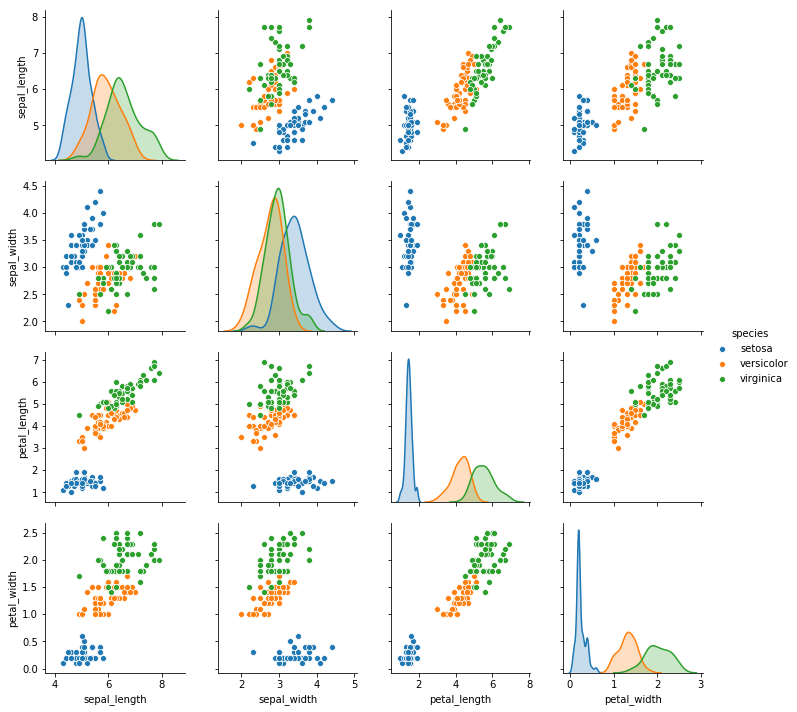

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

iris = sns.load_dataset("iris")
g = sns.pairplot(iris, hue="species")

In [10]:
from sklearn import datasets
iris = datasets.load_iris()
X = iris.data
y = iris.target

In [11]:
from sklearn.model_selection import train_test_split
(train_inputs, test_inputs, train_classes, test_classes) = train_test_split(X, y, train_size=0.8, random_state=1)

/home/emam/.conda/envs/py27/lib/python2.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


## Classification

In [12]:
dtc = DecisionTreeClassifier()
dtc.fit(train_inputs, train_classes)
dtc.score(test_inputs, test_classes)

0.9666666666666667

## Graph Visualization

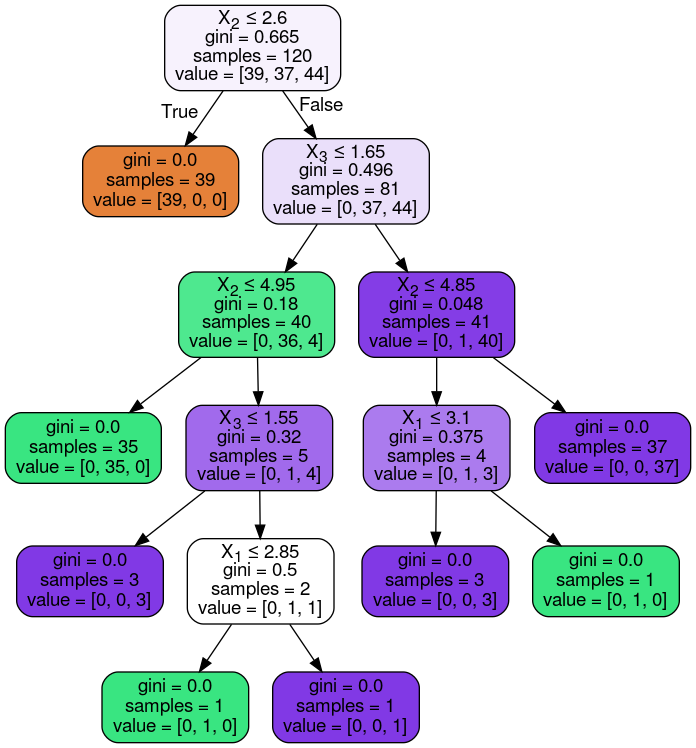

In [13]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

'''The ‘value’ row in each node tells us how many of the 
observations that were sorted into that node fall into each 
of our three categories.'''

dot_data = StringIO()
export_graphviz(dtc, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())



## References
[
Machine Learning: An Algorithmic Perspective: Stephen Marsland ](http://dai.fmph.uniba.sk/courses/ICI/References/marsland.machine-learning.2ed.2015.pdf)